In [ ]:
from toolbox.models import ResNet112, ResNet56
from toolbox.data_loader import Cifar100
from toolbox.utils import evaluate_model

import torch
import torch.nn as nn
import torch.nn.functional as F

import tensorly as tl
tl.set_backend("pytorch")

import matplotlib.pyplot as plt

device = "cuda"
BATCH_SIZE = 128
BATCH_INDEX = 0

In [ ]:
model_path = r"toolbox/Cifar100_ResNet112.pth"
model = ResNet112(100).to(device)
model.load_state_dict(torch.load(model_path, weights_only=True)["weights"])
model.eval()

mean, std = (0.5071, 0.4867, 0.4409), (0.267, 0.256, 0.276) 
Data = Cifar100(BATCH_SIZE)
trainloader, testloader = Data.trainloader, Data.testloader

evaluate_model(model, testloader)

inputs, targets = next(iter(testloader))
inputs, targets = inputs.to(device), targets.to(device)

outputs = model(inputs)



In [ ]:

probs = torch.nn.functional.softmax(outputs[3], dim=1)
confidence, predicted = torch.max(probs.data, 1)

def show_sample():
    predicted_class_label = testloader.dataset.classes[predicted[BATCH_INDEX]]
    correct_class_label = testloader.dataset.classes[targets[BATCH_INDEX]]
    print('predicted: ', predicted_class_label)
    print('correct: ', correct_class_label)
    print('confidence', confidence[BATCH_INDEX].item())
    img = inputs[BATCH_INDEX].cpu() * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    img = img.permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def show_model_fmap(t=outputs[2][BATCH_INDEX], size=3):
    fig, axs = plt.subplots(size, size,figsize=(3,3))  # You can adjust the figsize as needed
    for i in range(size):
        for j in range(size):
            axs[i,j].matshow(t[size*i+j].detach().cpu())
            axs[i,j].axis('off')  # Hide axis for clarity

    plt.tight_layout()
    plt.show()
# show_model_fmap()

In [ ]:
from tensorly import tucker_to_tensor
from typing import List, Union, Optional

def mode_n_product(tensor: torch.Tensor, matrix: torch.Tensor, mode: int) -> torch.Tensor:
    """
    Mode-n product of a tensor with a matrix.

    Parameters
    ----------
    tensor : torch.Tensor
        The input tensor.
    matrix : torch.Tensor
        The matrix to multiply (shape should match tensor.shape[mode]).
    mode : int
        The mode along which to multiply.

    Returns
    -------
    torch.Tensor
        The resulting tensor.
    """
    # Move mode axis to the front
    tensor = tensor.permute(mode, *[i for i in range(tensor.ndim) if i != mode])
    # Reshape to matrix
    orig_shape = tensor.shape
    tensor = tensor.reshape(tensor.shape[0], -1)
    # Matrix multiplication
    result = torch.matmul(matrix, tensor)
    # Reshape back
    new_shape = (matrix.shape[0],) + orig_shape[1:]
    result = result.reshape(new_shape)
    # Move axes back
    inverse_permutation = list(range(1, mode+1)) + [0] + list(range(mode+1, tensor.ndim))
    result = result.permute(inverse_permutation)
    return result

def multi_mode_dot(
    tensor: torch.Tensor,
    matrix_or_vector_list: List[Union[torch.Tensor, None]],
    modes: Optional[List[int]] = None,
    transpose: bool = False
) -> torch.Tensor:
    """
    n-mode product of a tensor and a list of matrices or vectors along specified modes.

    Parameters
    ----------
    tensor : torch.Tensor
        The input tensor.
    matrix_or_vector_list : list of torch.Tensor or None
        List of matrices or vectors to multiply with.
    modes : list[int], optional
        List of modes to multiply along. If None, defaults to range(len(matrix_or_vector_list)).
    transpose : bool, default is False
        If True, each matrix is transposed before multiplication.

    Returns
    -------
    torch.Tensor
        Result of the multi-mode product.
    """
    if modes is None:
        modes = list(range(len(matrix_or_vector_list)))

    for mat_or_vec, mode in zip(matrix_or_vector_list, modes):
        if mat_or_vec is not None:
            mat = mat_or_vec.T if transpose else mat_or_vec
            tensor = mode_n_product(tensor, mat, mode)
    return tensor


def mode_dot(tensor, matrix, mode):
    """
    Multiply a tensor by a matrix in a specified mode (dimension).
    tensor: shape (I0, ..., In, ..., IN)
    matrix: shape (J, In)
    returns: shape (I0, ..., J, ..., IN)
    """
    ndims = tensor.ndim
    # Move mode dim to front
    permute_dims = [mode] + [i for i in range(ndims) if i != mode]
    tensor_perm = tensor.permute(permute_dims)
    original_shape = tensor.shape

    # Perform matrix multiplication
    tensor_reshaped = tensor_perm.reshape(tensor.shape[mode], -1)  # (In, -1)
    result = torch.matmul(matrix, tensor_reshaped)  # (J, -1)

    # Reshape back
    new_shape = (matrix.shape[0],) + tuple(original_shape[i] for i in range(ndims) if i != mode)
    result = result.reshape(new_shape)

    # Inverse permutation
    inv_permute = [permute_dims.index(i) for i in range(ndims)]
    return result.permute(inv_permute)



In [ ]:
def reconstruct_error(reconstructed):
    original = outputs[2].detach()
    error = torch.norm(original - reconstructed) / torch.norm(original)
    return error


In [41]:
core, factors = tl.decomposition.tucker(outputs[2], rank=[BATCH_SIZE, 24, 8, 8])
core2, factors2 = tl.decomposition.tucker(outputs[2], rank=[BATCH_SIZE, 64, 8, 8])
print(core.shape, core2.shape)

torch.Size([128, 24, 8, 8]) torch.Size([128, 64, 8, 8])


In [ ]:
mins, maxs, means, stds, errs = [], [], [], [], []
for reduced_channel_size in range(64,0,-1):
    factors_reduced = [
        factors2[0],                      
        factors2[1][:, :reduced_channel_size],        
        factors2[2],       
        factors2[3],        
    ]
    partial_reconstruct = core2[:,:reduced_channel_size,:,:]
    for mode, factor in enumerate(factors_reduced):
        partial_reconstruct = mode_dot(partial_reconstruct, factor, mode)

    err = reconstruct_error(partial_reconstruct)

    mins.append(partial_reconstruct.min().detach().cpu())
    maxs.append(partial_reconstruct.max().detach().cpu())
    means.append(partial_reconstruct.mean().detach().cpu())
    stds.append(partial_reconstruct.std().detach().cpu())
    errs.append(err.detach().cpu())
    if reduced_channel_size % 8 == 0:
        print(reduced_channel_size)
        print(f'min value {partial_reconstruct.min():.6f}, max value {partial_reconstruct.max():.6f}, mean {partial_reconstruct.mean():.6f}, std {partial_reconstruct.std():.6f}')
        print(f'Reconstruction error: {err:.6f}')
        show_model_fmap(partial_reconstruct[BATCH_INDEX])
        print("=============================="*100)

plt.plot(mins,label='mins')
plt.plot(maxs, label='maxs')
plt.plot(means, label='means')
plt.plot(stds, label='stds')
plt.legend()
plt.show()
plt.plot(errs,label='reconstruct error')
plt.legend()
plt.show()

24
min value -3.087833, max value 8.823774, mean 0.977706, std 1.248484


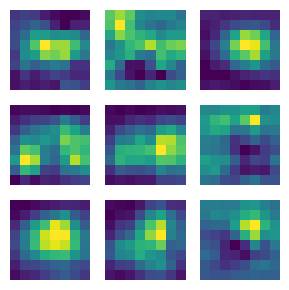

min value -3.087790, max value 8.823740, mean 0.977700, std 1.248474


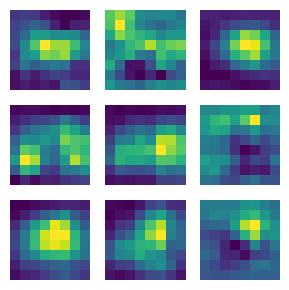

mean 0.000001, std 0.000022


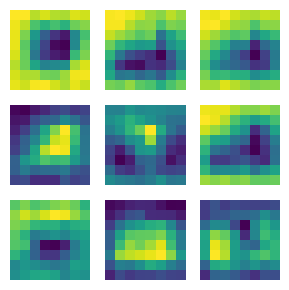

23
min value -2.856139, max value 9.146294, mean 0.976820, std 1.239992


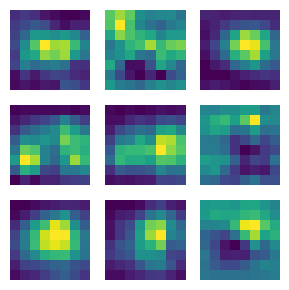

min value -2.856199, max value 9.146229, mean 0.976814, std 1.239984


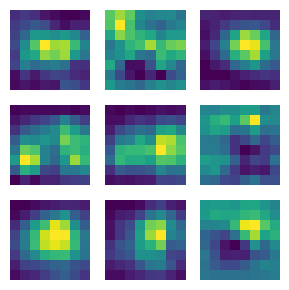

mean 0.000001, std 0.000023


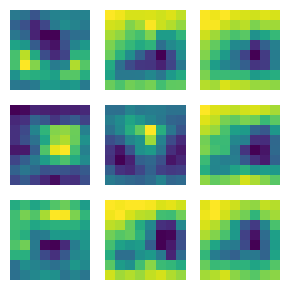

22
min value -3.058666, max value 9.169233, mean 0.977928, std 1.210730


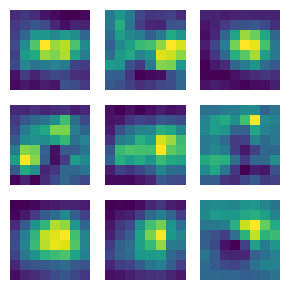

min value -3.058717, max value 9.169208, mean 0.977921, std 1.210726


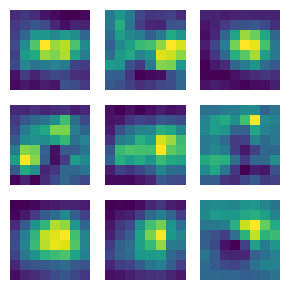

mean 0.000001, std 0.000014


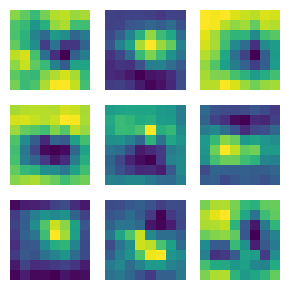

21
min value -3.070132, max value 9.038675, mean 0.978024, std 1.204403


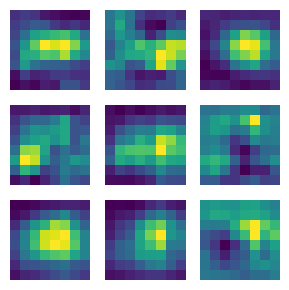

min value -3.070178, max value 9.038664, mean 0.978017, std 1.204399


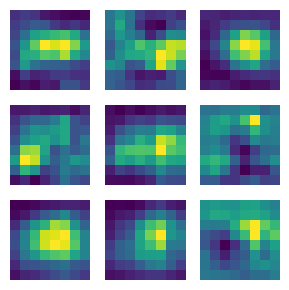

mean 0.000001, std 0.000015


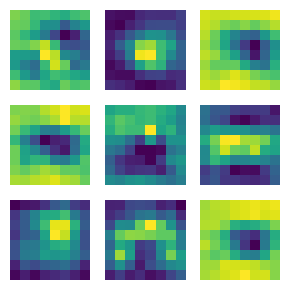

20
min value -3.241238, max value 8.671411, mean 0.971407, std 1.174181


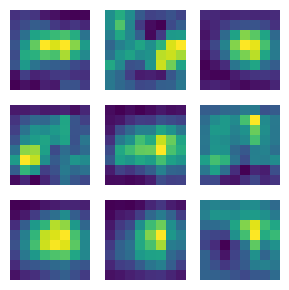

min value -3.241219, max value 8.671399, mean 0.971400, std 1.174177


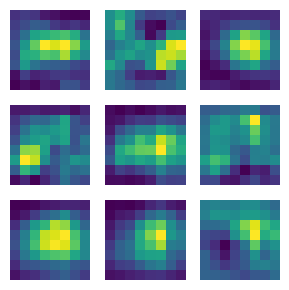

mean 0.000001, std 0.000014


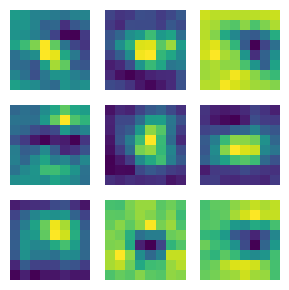

19
min value -3.196829, max value 8.829713, mean 0.971300, std 1.168537


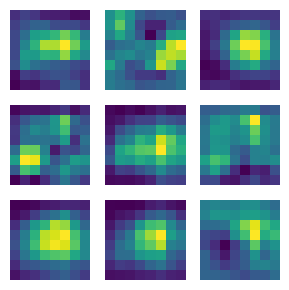

min value -3.196824, max value 8.829686, mean 0.971294, std 1.168534


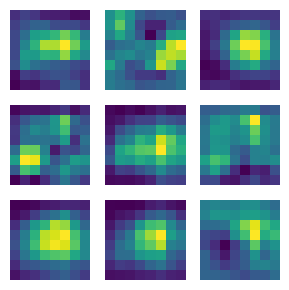

mean 0.000001, std 0.000014


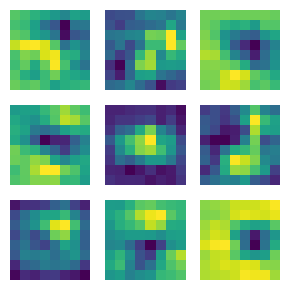

18
min value -3.099575, max value 9.024722, mean 0.966518, std 1.163927


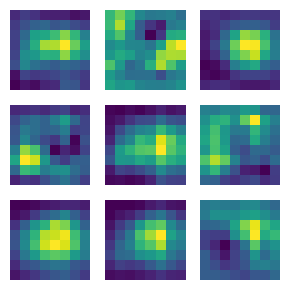

min value -3.099684, max value 9.024663, mean 0.966513, std 1.163927


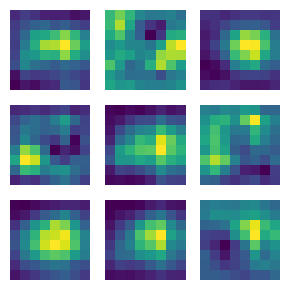

mean 0.000001, std 0.000033


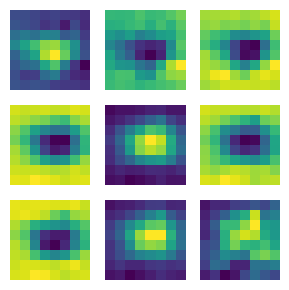

17
min value -3.013326, max value 8.545722, mean 0.968568, std 1.108504


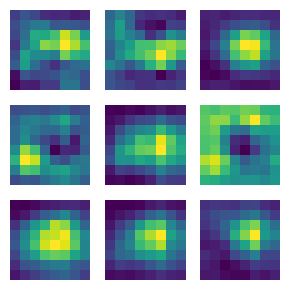

min value -3.013314, max value 8.545682, mean 0.968562, std 1.108502


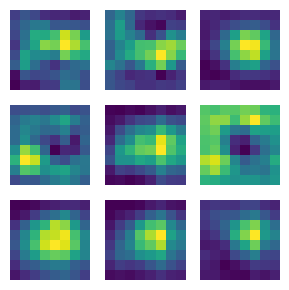

mean 0.000001, std 0.000014


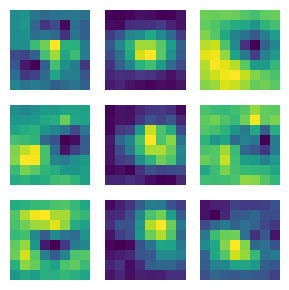

16
min value -2.568689, max value 8.119102, mean 0.969135, std 1.090805


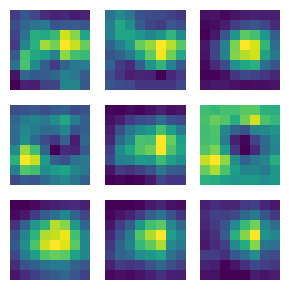

min value -2.568756, max value 8.119083, mean 0.969129, std 1.090801


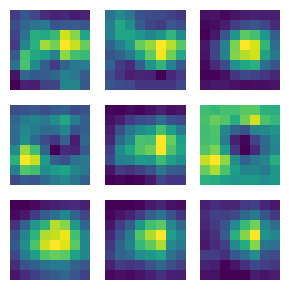

mean 0.000001, std 0.000030


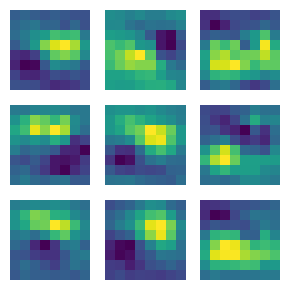

15
min value -2.522090, max value 8.283805, mean 0.969095, std 1.083410


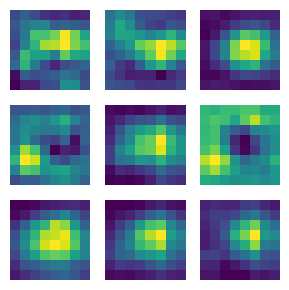

min value -2.522192, max value 8.283694, mean 0.969089, std 1.083408


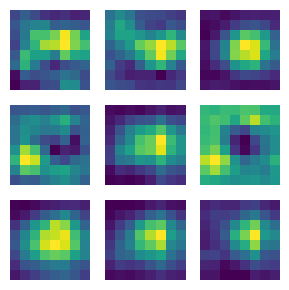

mean 0.000001, std 0.000028


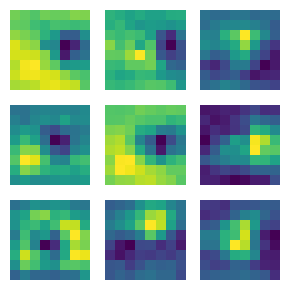

14
min value -2.165735, max value 8.554726, mean 0.970212, std 1.058484


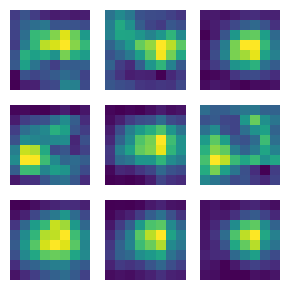

min value -2.166159, max value 8.554173, mean 0.970206, std 1.058435


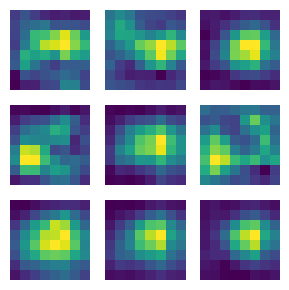

mean 0.000001, std 0.000363


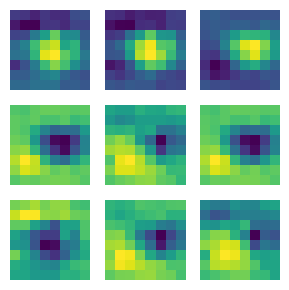

13
min value -2.233633, max value 7.236183, mean 0.968808, std 1.027787


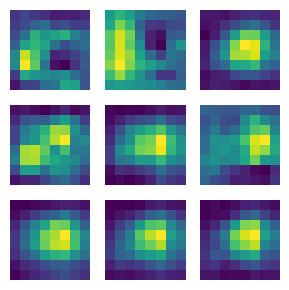

min value -2.233735, max value 7.236131, mean 0.968802, std 1.027785


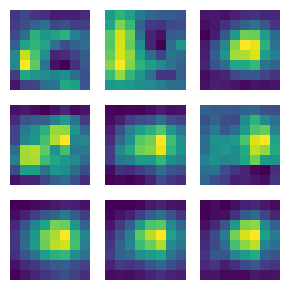

mean 0.000001, std 0.000014


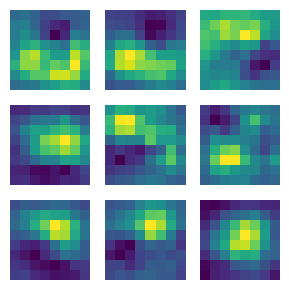

12
min value -1.937401, max value 7.102053, mean 0.968346, std 1.016602


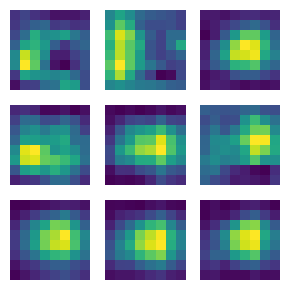

min value -1.937516, max value 7.101988, mean 0.968340, std 1.016598


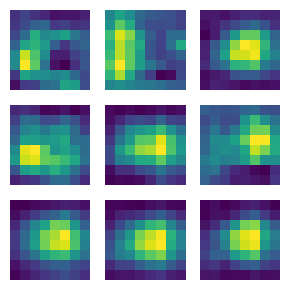

mean 0.000001, std 0.000022


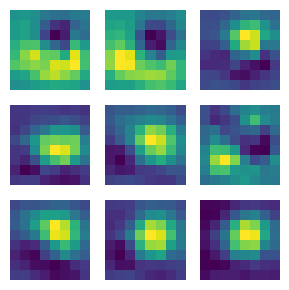

11
min value -1.384356, max value 7.387246, mean 0.961134, std 0.942118


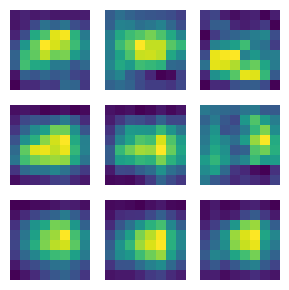

min value -1.384278, max value 7.387367, mean 0.961127, std 0.942107


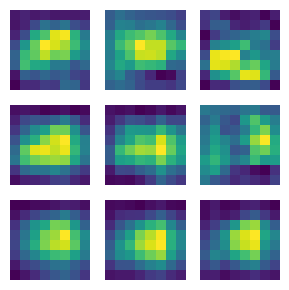

mean 0.000001, std 0.000040


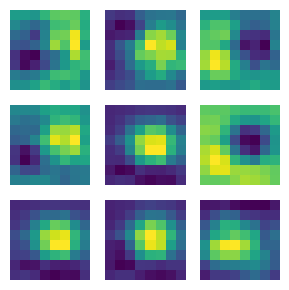

10
min value -1.446821, max value 7.983050, mean 0.954907, std 0.917353


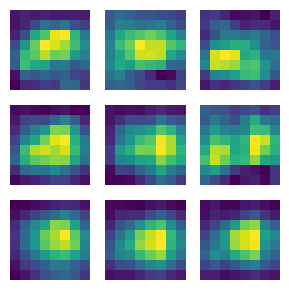

min value -1.446856, max value 7.982970, mean 0.954902, std 0.917349


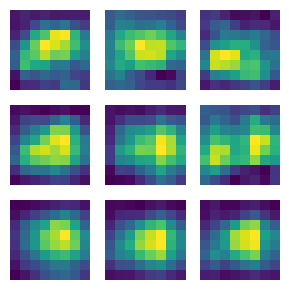

mean 0.000001, std 0.000019


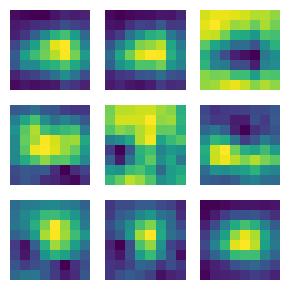

9
min value -1.231538, max value 8.150229, mean 0.952726, std 0.896303


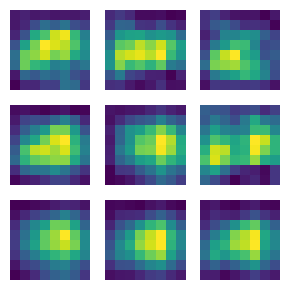

min value -1.231512, max value 8.150189, mean 0.952720, std 0.896297


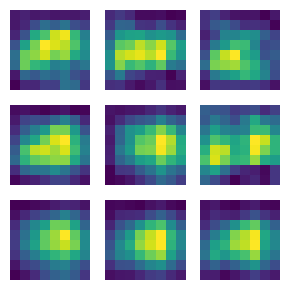

mean 0.000001, std 0.000026


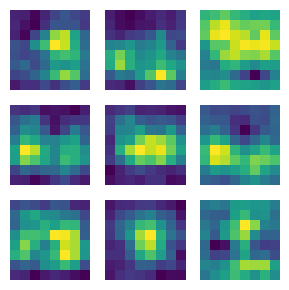

8
min value -0.571374, max value 7.901011, mean 0.943982, std 0.862285


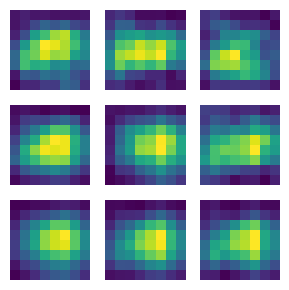

min value -0.571227, max value 7.900925, mean 0.943978, std 0.862276


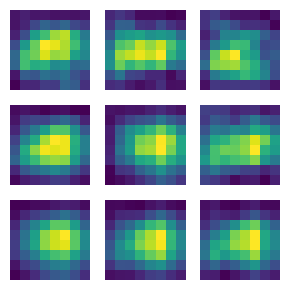

mean 0.000001, std 0.000047


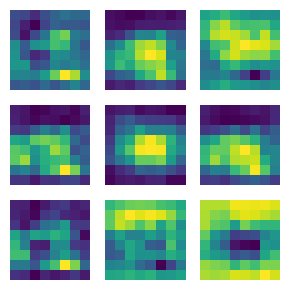

7
min value -0.531190, max value 7.870096, mean 0.943597, std 0.857377


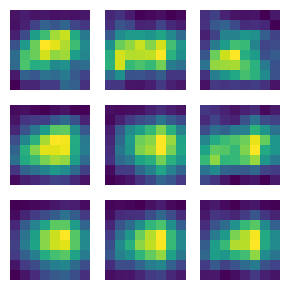

min value -0.531184, max value 7.870060, mean 0.943591, std 0.857371


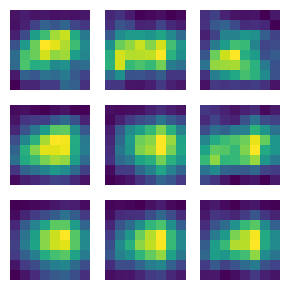

mean 0.000001, std 0.000013


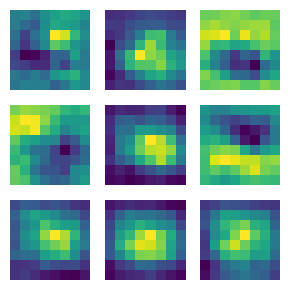

6
min value -0.402484, max value 7.893795, mean 0.941805, std 0.854623


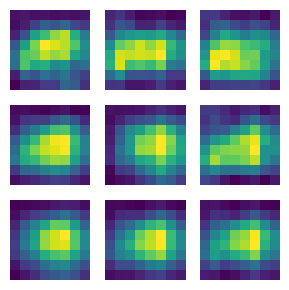

min value -0.402475, max value 7.893754, mean 0.941799, std 0.854618


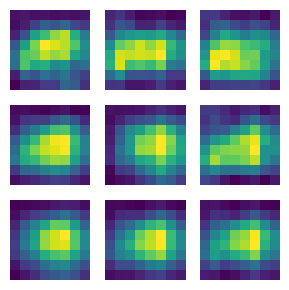

mean 0.000001, std 0.000022


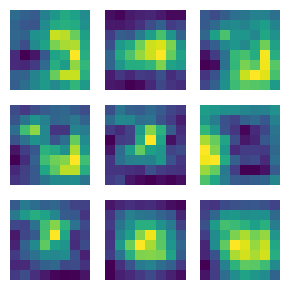

5
min value -0.408341, max value 7.664975, mean 0.943242, std 0.842198


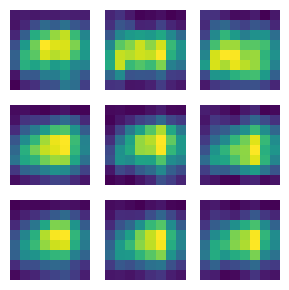

min value -0.408303, max value 7.664935, mean 0.943235, std 0.842193


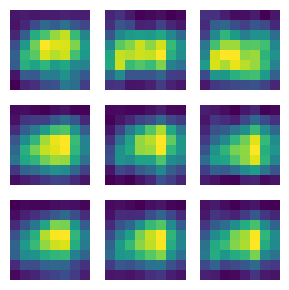

mean 0.000001, std 0.000030


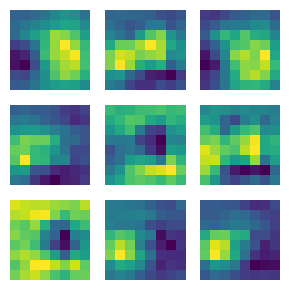

4
min value -0.503886, max value 6.356310, mean 0.957703, std 0.797647


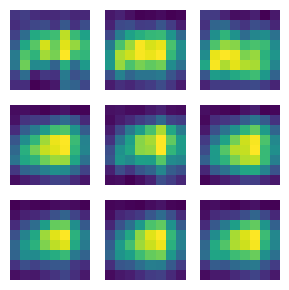

min value -0.503766, max value 6.356281, mean 0.957696, std 0.797641


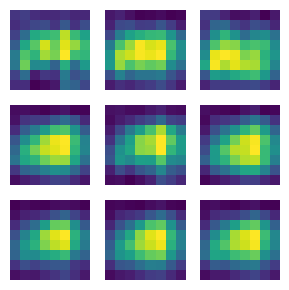

mean 0.000001, std 0.000025


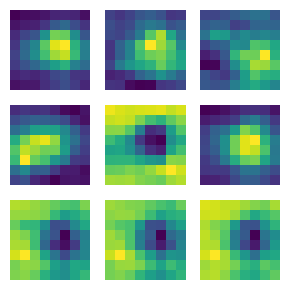

3
min value -0.430648, max value 6.004119, mean 0.955414, std 0.687874


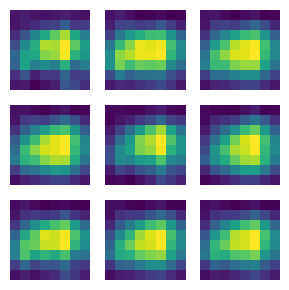

min value -0.430646, max value 6.004067, mean 0.955408, std 0.687870


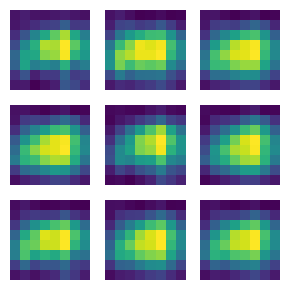

mean 0.000001, std 0.000010


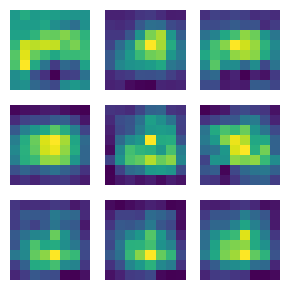

2
min value 0.045472, max value 5.772521, mean 0.954034, std 0.678085


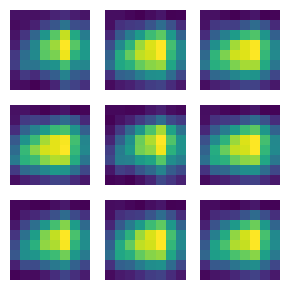

min value 0.045474, max value 5.772476, mean 0.954028, std 0.678081


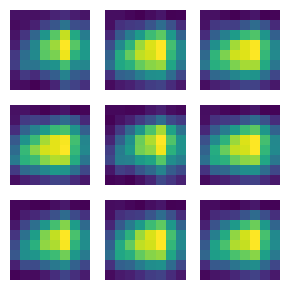

mean 0.000001, std 0.000008


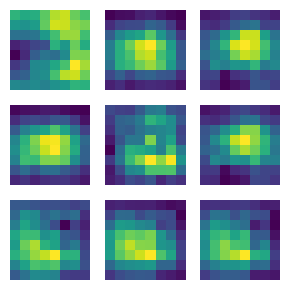

1
min value 0.108148, max value 5.273881, mean 0.960151, std 0.650114


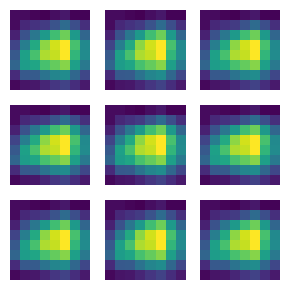

min value 0.108147, max value 5.273849, mean 0.960145, std 0.650110


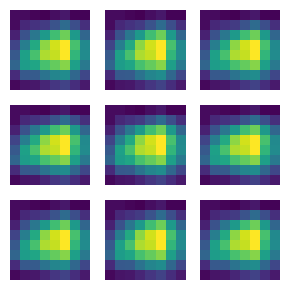

mean 0.000001, std 0.000004


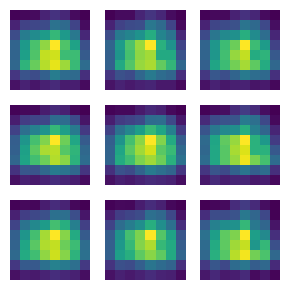

In [42]:

for reduced_channel_size in range(24,0,-1):
    print(reduced_channel_size)
    temp_recon_1 = torch.empty((128,64,8,8))
    temp_recon_2 = torch.empty((128,64,8,8))
    for i, (c, f) in enumerate([(core,factors), (core2,factors2)]):
        factors_reduced = [
            f[0],                      
            f[1][:, :reduced_channel_size],        
            f[2],       
            f[3],        
        ]
        partial_reconstruct = c[:,:reduced_channel_size,:,:]
        for mode, factor in enumerate(factors_reduced):
            partial_reconstruct = mode_dot(partial_reconstruct, factor, mode)
        if i == 0:
            temp_recon_1 = partial_reconstruct
        elif i ==1:
            temp_recon_2 = partial_reconstruct

        if reduced_channel_size % 1 == 0:
            selected_recon = partial_reconstruct[BATCH_INDEX]
            print(f'min value {selected_recon.min():.6f}, max value {selected_recon.max():.6f}, mean {selected_recon.mean():.6f}, std {selected_recon.std():.6f}')
            reconstruct_error(partial_reconstruct)
            show_model_fmap(partial_reconstruct[BATCH_INDEX])
    difference = temp_recon_1 - temp_recon_2        
    print(f'mean {difference.mean():.6f}, std {difference.std():.6f}')
    show_model_fmap(difference[BATCH_INDEX])
    print("=============================="*100)
